In [19]:
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import aggregator as ag

In [2]:
#data_file_name_review = "distributed_data_collection/databases/review_data_sample.csv"
#data_file_name_book = "distributed_data_collection/databases/book_data_sample.csv"

data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 11, 29)

#book_columns = ["num_reviews", "num_ratings", "avg_rating"] ##THIS IS BASELINE
book_columns = ["num_reviews", "num_ratings", "avg_rating", "book_language", "series", "book_author"]

Theoretically, we could test against multiple grains (ie, day, week, month, quarter). However, I am only working with month. I ruled out the quarterly grain because it wouldn't include enough 2020 time periods to observe a trend in model performance over time. Then because the maximum monthly review counts were in the seventies, I didn't feel I could split those further.

In [3]:
data_aggregator = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns, start_date, end_date, "month")
data = data_aggregator.aggregate("by_book")

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.


I want to drop binary feature columns which have a small number of values. The linear regression regularization will do a rigorous feature selection, so this step is mostly to reduce the amount of data that it has to process.

In [4]:
columns_dropped = []
k = 2

for col in data.columns:
    
    num_values = data[col].nunique()
    
    if num_values == 1:
        columns_dropped.append(col)
        
    elif num_values == 2:
        if data[col].sum() <=2:
            columns_dropped.append(col)
            
for col in columns_dropped:
    data.drop(columns = col, inplace = True)

I want to get a sense of how many features got dropped. I assume a ton!

In [5]:
num_col_dropped = len(columns_dropped)
num_col_remaining = len(data.columns)

print("{} columns dropped, {} columns remaining".format(num_col_dropped, num_col_remaining))

#print(columns_dropped)
data_copy = data.copy()

10113 columns dropped, 2185 columns remaining


This process will take all the 2018-2019 periods as features and will use those to predict reviews for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model may indicate COVID-related change.

In [6]:
time_periods_post = []

for col in data.columns:
    if "review_count" in col:
        if "2020" in col:
            time_periods_post.append(col)

I want to use the same test/train split for every time period, so I need to make the split before selecting which period will be the feature. 

In [7]:
perc_train = 0.75

data = data.iloc[np.random.permutation(data.index)].reset_index(drop=True) #SHUFFLES DATA

num_observations_total = len(data)
num_observations_train = int(num_observations_total* perc_train)
num_observations_test = num_observations_total - num_observations_train

data_train = data.head(num_observations_train).reset_index(drop = True)
data_test = data.tail(num_observations_test).reset_index(drop = True)

We want to iterate through: logorithmic transformation, regularization type, and alpha value. For the moment, I am turning logorithmic transformation off. It's pretty clear that it has no impact, and I don't want to keep running it while I experiment with other aspects of the modeling process.

In [8]:
alpha_list = list(range(1,11))
regression_types_list = ["linear", "ridge", "lasso"]

#is_log_options = [False, True]
is_log_options = [False] 

Here goes on modeling! We will select the best model for each time period based on MSE.

In [51]:
#JUST FOR PROGRESS PRINTING

num_models = len(regression_types_list)
num_periods = len(time_periods_post)
num_is_log_options = len(is_log_options)
num_alphas = len(alpha_list)

num_models_total = (num_periods * num_is_log_options) * ( (num_alphas * (num_models - 1)) + 1)
num_models_complete = 0
model_dict = {}

#ACTUAL MODELING
performance_df = pd.DataFrame(columns = ["post_period", "regression_type", "is_log", "alpha", "mse_test", "r2_train", "r2_test"])

for i in range(len(time_periods_post)): #ITERATE OVER EACH PERIOD IN THE POST PERIOD
    
    label = time_periods_post[i]
    
    data_train_period = data_train.copy()
    data_test_period = data_test.copy()
    
    #REMOVE OTHER POST-PERIODS FROM DATA 
    
    for post_period in time_periods_post:

        if post_period != label:
            data_train_period.drop(columns = post_period, inplace = True)
            data_test_period.drop(columns = post_period, inplace = True)
                   
    #CREATE TRAINING & TESTING DATA SPECIFIC TO THAT PERIOD 

    x_train, y_train = data_train_period.drop(label,1), data_train_period[label]
    x_test, y_test = data_test_period.drop(label,1), data_test_period[label]
        
    optimal_model = None
    optimal_regression_type = None
    optimal_mse_test = None
    optimal_is_log = None
    optimal_alpha = None
    is_none = True
    
    for regression_type in regression_types_list:
        for is_log in is_log_options:
            for alpha_val in alpha_list:
                
                if regression_type == "linear":
                    model = LinearRegression(normalize = True)
                    
                if regression_type == "ridge":
                    model = Ridge(normalize = True, alpha = alpha_val) 
                    
                if regression_type == "lasso":
                    model = Lasso(normalize = True, alpha = alpha_val)
            
                model.fit(x_train, y_train)
                mse_test = metrics.mean_squared_error(y_test, model.predict(x_test))

                if is_none:
                    optimal_model = model
                    optimal_mse_test = mse_test
                    optimal_regression_type = regression_type
                    optimal_is_log = is_log
                    
                    if regression_type == "linear":
                        alpha_val = None
                    
                    optimal_alpha = alpha_val

                    is_none = False

                elif mse_test < optimal_mse_test:

                    optimal_model = model
                    optimal_mse_test = mse_test
                    optimal_regression_type = regression_type
                    optimal_is_log = is_log
                    
                    if regression_type == "linear":
                        alpha_val = None
                    
                    optimal_alpha = alpha_val

                #PRINT UPDATES

                num_models_complete +=1

                if (num_models_complete % 10 == 0) or (num_models_complete == num_models_total):
                    print("{}/{} models processed".format(num_models_complete, num_models_total))
                    
                if regression_type == "linear":
                    break
                
    #GET METRICS FOR WINNING MODEL
    
    #mse_train = metrics.mean_squared_error(y_train, optimal_model.predict(x_train))
    mse_test = metrics.mean_squared_error(y_test, optimal_model.predict(x_test))

    r2_train = metrics.r2_score(y_train, optimal_model.predict(x_train))
    r2_test = metrics.r2_score(y_test, optimal_model.predict(x_test))
        
    metric_dict = {"post_period": label, "regression_type": optimal_regression_type, "is_log": optimal_is_log, "alpha": optimal_alpha, "mse_test": mse_test, "r2_train": r2_train, "r2_test": r2_test}
    performance_df = performance_df.append(metric_dict, ignore_index=True)
    model_dict[label] = optimal_model

10/231 models processed
20/231 models processed
30/231 models processed
40/231 models processed
50/231 models processed
60/231 models processed
70/231 models processed
80/231 models processed
90/231 models processed
100/231 models processed
110/231 models processed
120/231 models processed
130/231 models processed
140/231 models processed
150/231 models processed
160/231 models processed
170/231 models processed
180/231 models processed
190/231 models processed
200/231 models processed
210/231 models processed
220/231 models processed
230/231 models processed
231/231 models processed


The performance df captures the overall predictiveness of pre-period data on post-period data. We expect to see declines due to concept drift. Sharp dropoffs in performance might suggest larger changes in reading trends.

In [52]:
performance_df["post_period"] = performance_df["post_period"].apply(lambda text: text.replace("review_count ", ""))
print(performance_df.round(3))

   post_period regression_type is_log alpha  mse_test  r2_train  r2_test
0      2020-01           ridge  False     1     3.587     0.807    0.744
1      2020-02           ridge  False     1     2.025     0.729    0.654
2      2020-03           ridge  False     1     2.259     0.718    0.642
3      2020-04           ridge  False     1     3.710     0.768    0.703
4      2020-05           ridge  False     1     4.188     0.715    0.615
5      2020-06           ridge  False     1     4.042     0.620    0.568
6      2020-07           ridge  False     2     3.486     0.616    0.570
7      2020-08           ridge  False     1     2.330     0.646    0.594
8      2020-09           ridge  False     2     2.367     0.587    0.525
9      2020-10           ridge  False     3     1.501     0.519    0.414
10     2020-11           ridge  False     5     0.018     0.085    0.029


This is where it's really at! Understanding what features are most important to each model can help us understand the drivers of reading in each period.

In [53]:
coefficient_dict = {}

for period in time_periods_post:
    period_name = period.replace("review_count ", "")
    
    model = model_dict.get(period)
    coefficients = model.coef_
    #intercept = model.intercept_
    
    coefficient_dict[period_name] = coefficients
    
coefficient_df = pd.DataFrame.from_dict(coefficient_dict)

feature_data = data.copy()

for col in feature_data.columns:
    if col in time_periods_post:
        feature_data.drop(columns = col, inplace = True)
        
feature_names = feature_data.columns

coefficient_df["feature_name"] = feature_names
coefficient_df.set_index("feature_name", inplace = True)

#print(coefficient_df.round(3))

                           2020-01  2020-02  2020-03  2020-04  2020-05  \
feature_name                                                             
book_id                      0.000    0.000    0.000    0.000    0.000   
review_count 2018-01         0.037    0.026    0.027    0.041    0.030   
review_count 2018-02         0.036    0.033    0.026    0.057    0.037   
review_count 2018-03         0.051    0.031    0.027    0.047    0.034   
review_count 2018-04         0.022    0.023    0.027    0.051    0.024   
...                            ...      ...      ...      ...      ...   
book_author_Nancy Thayer    -0.396    0.186    0.178   -0.417    0.611   
book_author_Brad Thor        0.022   -0.083   -0.084    0.021   -0.113   
book_author_T.A. White      -0.127    0.128    0.363    0.622    0.317   
book_author_Sierra Simone    0.058   -0.133    0.065   -0.221    0.087   
book_author_Hazel Gaynor     0.273   -0.199   -0.207   -0.224   -0.269   

                           2020-06  2

In [69]:
for period in coefficient_df.columns:
    
    selected_df = coefficient_df.copy()
    
    abs_name = "{}_abs".format(period)
    
    selected_df[abs_name] = selected_df[period].apply(lambda val: abs(val))
    selected_df = selected_df[[period, abs_name]]
    selected_df.sort_values(by=abs_name, ascending=False, inplace = True)
    
    selected_df = selected_df.head(10)
    selected_df.drop(columns = abs_name, inplace = True)
    
    print(selected_df)

                                   2020-01
feature_name                              
book_author_Jeanine Cummins       7.947395
series_Alex Stern                 4.423045
series_5 Love Languages           4.041058
book_author_Yann Martel           3.973638
book_author_Audrey Niffenegger    3.559561
book_author_Jandy Nelson         -3.226352
book_author_Liz Moore             3.118619
book_author_Jennifer Hillier      3.117928
book_author_Casey McQuiston       2.988198
book_author_Parker S. Huntington  2.895201
                                                     2020-02
feature_name                                                
book_author_Jeanine Cummins                         6.355091
book_author_Jennifer Hillier                        2.727956
book_author_Erica Bauermeister                      2.708877
book_author_Jandy Nelson                           -2.548457
book_author_Parker S. Huntington                    2.390013
series_Crescent City                                2.354

I also want to understand the relative importance of each historical period. Even if it isn't the main driver, it should give some indication of whether trends are changing.

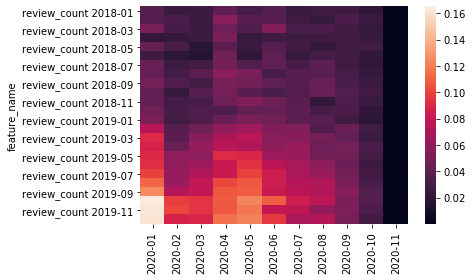

In [74]:
coefficient_historical_df = coefficient_df[coefficient_df.index.str.contains("review_count")]
#print(coefficient_historical_df)

sns.heatmap(coefficient_historical_df)
plt.show()